In [1]:
import os
import sys
sys.path.append('/app/RandStainNA')
sys.path.append('/app/BreastAgeNet')

import json
import yaml
import h5py
import random
from pathlib import Path
from typing import Tuple, Any, Optional

import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.preprocessing import label_binarize

import openslide  
from pySankey.sankey import sankey
from fastai.vision.all import *

from randstainna import RandStainNA
from utils.utils_model import *
from utils.utils_vis import *

In [9]:
basedir = '/app/figures/Fig2'
os.listdir(basedir)

['test_NR_clean_10repeats.csv']

In [3]:
# Load BreastAgeNet predictions for the test_NR dataset
NR_raw = pd.read_csv(f"{basedir}/test_NR_clean_10repeats.csv", low_memory=False)
NR_df = get_averaged_outputs(NR_raw)
NR_df

,wsi_id,patient_id,cohort,source,age,age_group,branch_0,branch_1,branch_2,sigmoid_0,sigmoid_1,sigmoid_2,binary_0,binary_1,binary_2,final_prediction
0,Human_016_s01,Human_016_s01,EPFL,RM,28,0,-0.396635,-2.487690,-6.082967,0.402121,0.076726,0.002276,0,0,0,0
250,Human_027_s01,Human_027_s01,EPFL,RM,31,0,0.699661,-0.924342,-5.144150,0.668113,0.284074,0.005800,1,0,0,1
500,Human_035_s01,Human_035_s01,EPFL,RM,26,0,1.686428,0.256894,-2.520374,0.843754,0.563873,0.074442,1,1,0,2
624,Human_103_s01,Human_103_s01,EPFL,RM,17,0,-0.408176,-1.509857,-5.267169,0.399349,0.180960,0.005132,0,0,0,0
874,Human_129_s01,Human_129_s01,EPFL,RM,18,0,-1.427090,-3.432115,-5.972155,0.193553,0.031307,0.002542,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24228,19004666_FPE_4,19004666,KHP,RM,41,1,0.781196,-1.726692,-3.341472,0.685938,0.151011,0.034176,1,0,0,1
24478,19004666_FPE_5,19004666,KHP,RM,41,1,1.276945,-1.382005,-3.329660,0.781929,0.200687,0.034568,1,0,0,1
24728,19004618_FPE_3,19004618,KHP,RM,42,1,2.484358,0.811346,-1.355033,0.923038,0.692396,0.205049,1,1,0,2
24978,19004618_FPE_1,19004618,KHP,RM,42,1,3.311242,1.725912,-0.342145,0.964812,0.848889,0.415289,1,1,0,2


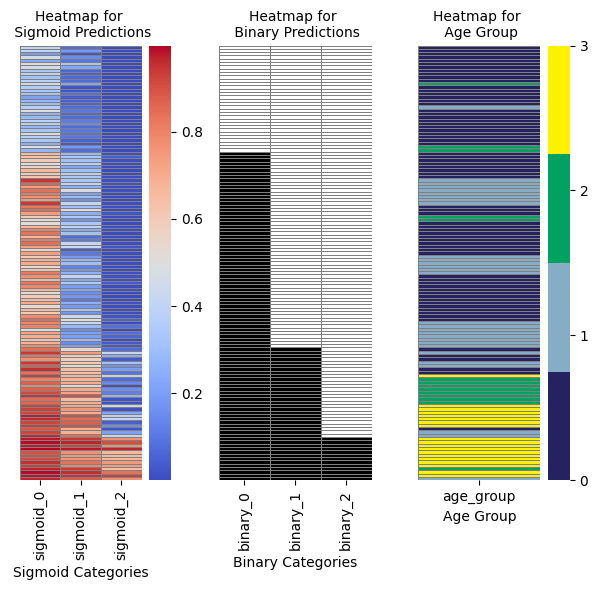

In [4]:
# Heatmaps visualising branch and overall tissue ageing predictions
NR_df = NR_df.sort_values(by=["binary_0", "binary_1", "binary_2"], ascending=[True, True, True])
vis_branch_predictions(NR_df, save_pt=None)

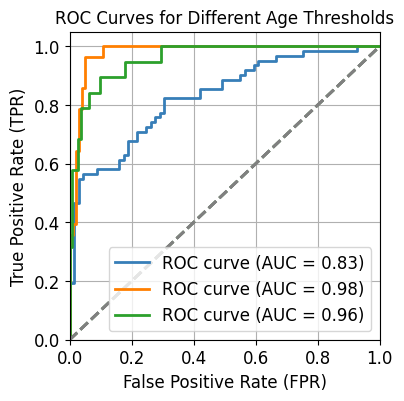

In [5]:
# ROC curves assessing branch performance
colors = ["#377EB8", "#4DAF4A", "#FF7F00"]  # Blue, Green, Orange

fig, ax = plt.subplots(figsize=(4, 4))  
branch_ROC(NR_df, branch=0, class_name=">rank0", ax=ax, fontsize=12, line_thickness=2)
branch_ROC(NR_df, branch=1, class_name=">rank1", ax=ax, fontsize=12, line_thickness=2)
branch_ROC(NR_df, branch=2, class_name=">rank2", ax=ax, fontsize=12, line_thickness=2)

for line, color in zip(ax.get_lines(), colors):
    line.set_color(color)

ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  # Diagonal reference line
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title('ROC Curves for Different Age Thresholds', fontsize=12)
ax.legend(loc="lower right", fontsize=12)
ax.grid(True)
plt.show()

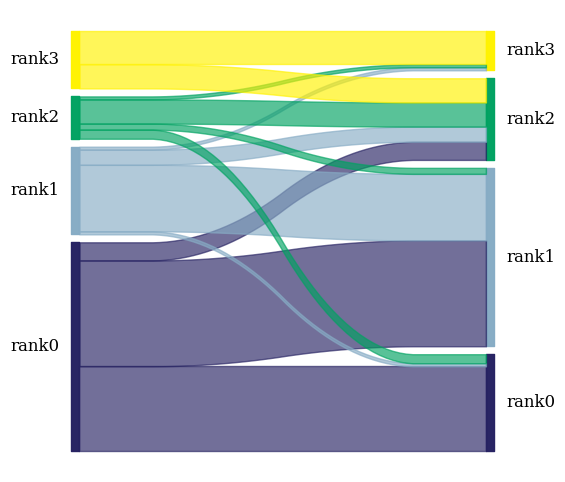

In [6]:
# Sankey diagram visualising the mapping between ground-truth and prediction
NR_df = NR_df.sort_values(by=["age_group", "final_prediction"])
y_true = [f"rank{i}" for i in list(NR_df["age_group"])]
y_pred = [f"rank{i}" for i in list(NR_df["final_prediction"])]
colors = {'rank0': "#262262", 'rank1': "#87ACC5", 'rank2': "#00A261", 'rank3': "#FFF200"}
sankey(y_true, y_pred, aspect=20, colorDict=colors, fontsize=12)

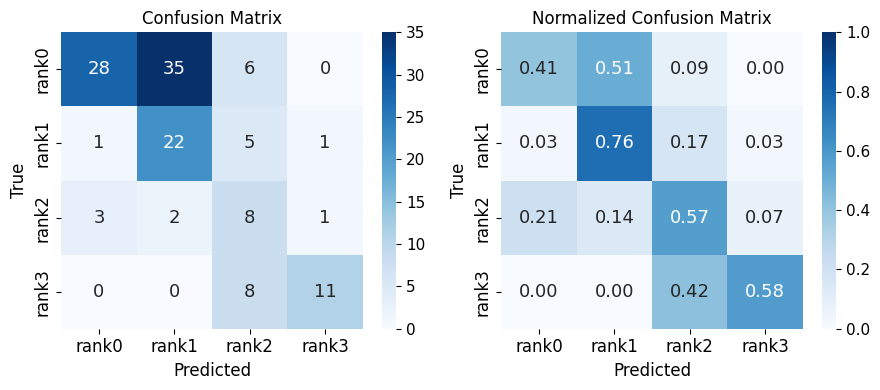

In [7]:
# Plot confusion matrix
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans"]

y_true = [f"rank{i}" for i in NR_df.loc[:, "age_group"].values]
y_pred = [f"rank{i}" for i in NR_df.loc[:, "final_prediction"].values]

fig, axes = plt.subplots(1, 2, figsize=(9, 4))  
plot_cm(y_true, y_pred, fontsize=12, save_pt=None, ax=axes[0])
plot_cm_norm(y_true, y_pred, fontsize=12, save_pt=None, ax=axes[1])
plt.tight_layout()
plt.show()

/app/BreastAgeNet/utils/utils_vis.py:199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(patient_ids_sorted, fontsize=10, rotation=90)


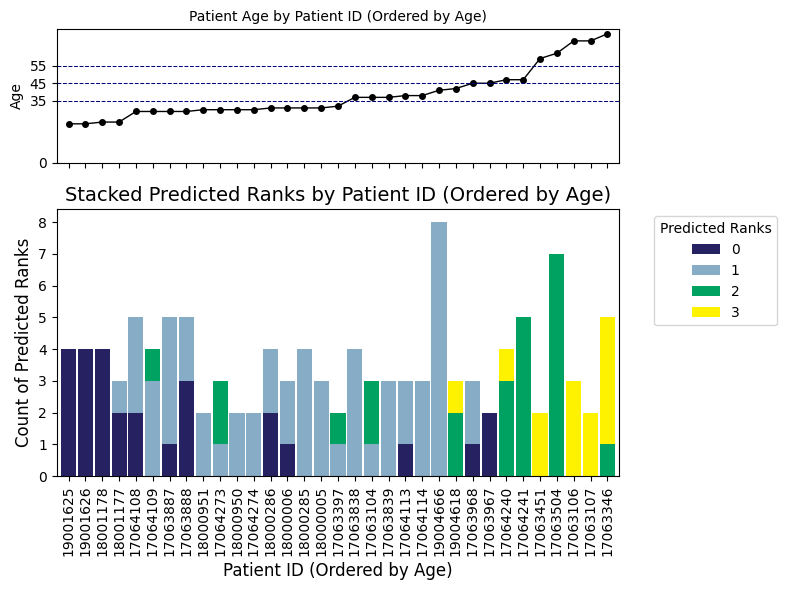

In [8]:
# Visualise predictions of multiple slides from the same patient 
patient_id_counts = NR_df['patient_id'].value_counts()
patient_ids_more_than_once = patient_id_counts[patient_id_counts > 1].index
NR_multiple = NR_df[NR_df['patient_id'].isin(patient_ids_more_than_once)].copy()
barplot_multiple_WSIs(NR_multiple, save_pt=None)